In [17]:
using JSON, JLD, PrettyTables
res = JSON.parsefile(".estimates/to_from_by_year.json");
id_to_type = JSON.parsefile(".estimates/id_to_type_api.json");

At the moment, this project tries to assign scores based on the expected value of their 
hires given current estimates.

Because of the sampling issue it doesn't say much.  For example scores for tier 5 schools will be 
very low just because so few of the tier 5 schools hires were recorded.

Maybe it is best to be conditional on hiring, but not sure what that means.

In [9]:
#the first column of all_data is current value estimates
all_data = load(".estimates/current_estimates.jld")
data = all_data["all_data"]

5×4 Matrix{Float64}:
 1.0       0.716341   0.208989     0.166853
 0.710386  0.54855    0.193632     0.200747
 0.568237  0.468296   0.131668     0.203959
 0.452448  0.20868    0.0378186    0.14838
 0.202149  0.0781195  0.000492491  0.280062

In [10]:
# the value estimates
values = data[:, 1]

5-element Vector{Float64}:
 1.0
 0.7103858833774259
 0.5682366032950542
 0.45244820978688893
 0.2021491796414182

In [12]:
# used to calculate scores for each university
scaled_values = 100*values

5-element Vector{Float64}:
 100.0
  71.0385883377426
  56.82366032950542
  45.24482097868889
  20.214917964141822

In [4]:
q = [[0.648419  0.0932438  0.0361411  0.00529313];
 [0.416424  0.176585   0.0793012  0.010537];
 [0.258063  0.227811   0.12451    0.0158831];
 [0.118784  0.156689   0.127757   0.0783047]]

4×4 Matrix{Float64}:
 0.648419  0.0932438  0.0361411  0.00529313
 0.416424  0.176585   0.0793012  0.010537
 0.258063  0.227811   0.12451    0.0158831
 0.118784  0.156689   0.127757   0.0783047

In [5]:
sum(q, dims=2)

4×1 Matrix{Float64}:
 0.78309703
 0.6828472
 0.6262671000000001
 0.4815347

In [6]:
size(q,2)

4

In [7]:
sp = res["specific"]
tier1_scores = Any[]
tier2_scores = Any[]
tier3_scores = Any[]
tier4_scores = Any[]
for (k,v) in sp 
    #println(k)
    for (key,value) in v
        tier = v["vse-ejm"]
        if(key == "name")
            #println(value)
        end
        if(key == "total_placements_from")
            #println(value)
            #println(tier)
            norm = value
            #sum(value)
            #println(norm)
            #println(norm)
            #println(scaled_values)
            score = transpose(norm)*values
            #println(score)
            if tier == 1
                push!(tier1_scores, score);
            elseif tier == 2
                push!(tier2_scores, score);
            elseif tier == 3
                push!(tier3_scores, score);
            else 
                push!(tier4_scores, score);
            end
            #println("Score: ",score)  
        end
    end
end

In [8]:
t1scores = sort(collect(skipmissing(tier1_scores)),rev=false)
t2scores = sort(collect(skipmissing(tier2_scores)),rev=false)
t3scores = sort(collect(skipmissing(tier3_scores)),rev=false)
t4scores = sort(collect(skipmissing(tier4_scores)),rev=false)
length(t1scores)+length(t2scores)+length(t3scores)+length(t4scores)

373

In [24]:
#length(a[a .< x])/length(a)
function dist(a)
    b = Any[]
    for (index,value) in enumerate(a)
        push!(b,length(a[a .<= value])/length(a))
    end
    return b
end
            

dist (generic function with 2 methods)

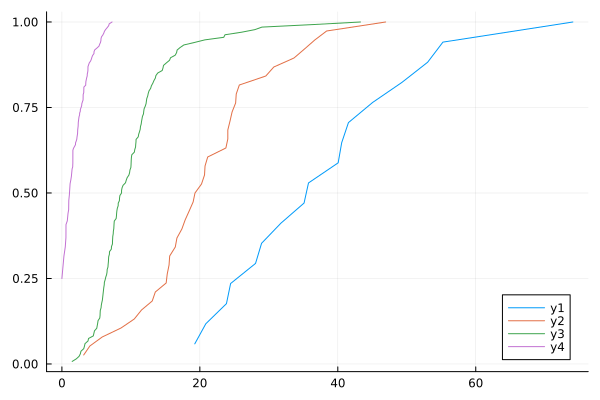

In [29]:
#using Pkg
#Pkg.add("Plots")
using Plots
y = dist(t1scores)
x = t1scores
plot(x,y)
y = dist(t2scores)
x = t2scores
plot!(x,y)
y = dist(t3scores)
x = t3scores
plot!(x,y)
y = dist(t4scores)
x = t4scores
plot!(x,y)

In [13]:
t1scores

17-element Vector{Any}:
 19.263332361393104
 20.865973490733097
 23.857408069570177
 24.460049198910166
 28.075180945038966
 28.94971985693498
 31.75260566541656
 35.10904452217719
 35.75260566541656
 40.054124907087235
 40.56445424906242
 41.543795565112056
 45.04595683992567
 49.30576135969425
 53.02490080197395
 55.242276323441374
 74.07902570906118

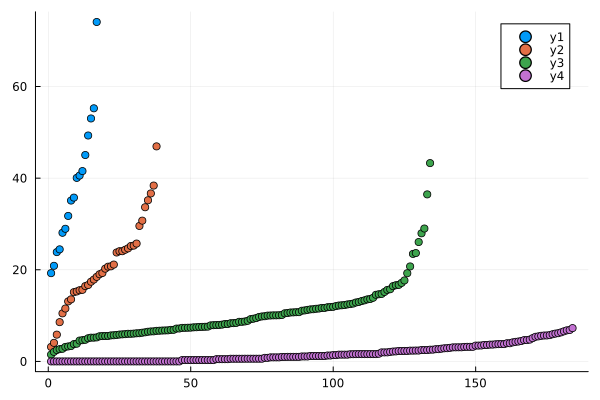

In [14]:
using Plots
scatter(t1scores)
scatter!(t2scores)
scatter!(t3scores)
scatter!(t4scores)